In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
filepath = '/workdir/energy-code-eval/data/sub_experiments/exp5_warmupGPU/processed.csv'
df = pd.read_csv(os.path.join(os.path.abspath(os.path.curdir), filepath))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Group by start_time proximity to identify different execution rounds
# Experiments within the same round should be close in time

# Sort by start_time
df = df.sort_values('start_time')

# Calculate time difference between consecutive rows
df['time_diff'] = df['start_time'].diff()

# Identify execution round boundaries (where time gap > 1000 seconds)
round_boundaries = df[df['time_diff'] > 1000].index.tolist()
round_starts = [0] + round_boundaries
round_ends = round_boundaries + [len(df)]

# Create a dictionary to store each round
execution_rounds = {}

for i in range(len(round_starts)):
    start_idx = round_starts[i]
    end_idx = round_ends[i]
    
    round_df = df.iloc[start_idx:end_idx].copy()
    
    # Check if this round has 9 experiments (3 mns x 3 max_tokens)
    if len(round_df) == 9:
        execution_rounds[f'round_{i+1}'] = round_df

# Verify the structure of the rounds
print(f"Found {len(execution_rounds)} complete execution rounds")

# Example: Show the mns and max_tokens combinations in the first round
for round_name, round_data in execution_rounds.items():
    configs = round_data[['mns', 'max_tokens']].values
    print(f"\n{round_name} configurations:")
    print("mns  |  max_tokens")
    print("------------------")
    for config in configs:
        print(f"{config[0]:<4} |  {config[1]}")
    
    # Only show the first round as example
    if round_name == 'round_1':
        break

# Create a dictionary with standardized structure for easier access
structured_rounds = {}

for round_name, round_data in execution_rounds.items():
    # Create a nested dictionary for this round
    round_dict = {}
    
    for _, row in round_data.iterrows():
        mns = row['mns']
        max_tokens = row['max_tokens']
        
        if mns not in round_dict:
            round_dict[mns] = {}
        
        round_dict[mns][max_tokens] = {
            'elapsed_time': row['elapsed_time'],
            'gpu0_energy': row['gpu0_energy'],
            'first_token_time': row['first_token_time'],
            'token_per_second': row['token_per_second'],
            'energy_per_token': row['energy_per_token']
        }
    
    structured_rounds[round_name] = round_dict

# Access example: print throughput (tokens/sec) for mns=128, max_tokens=512 in round 1
print("\nExample data access:")
print(f"Round 1, mns=128, max_tokens=512 throughput: {structured_rounds['round_1'][128][512]['token_per_second']:.2f} tokens/sec")
print(f"Round 1, mns=64, max_tokens=256 energy: {structured_rounds['round_1'][64][256]['energy_per_token']:.5f} J/token")

Found 3 complete execution rounds

round_1 configurations:
mns  |  max_tokens
------------------
128  |  128
64   |  128
32   |  128
128  |  256
64   |  256
32   |  256
128  |  512
64   |  512
32   |  512

Example data access:
Round 1, mns=128, max_tokens=512 throughput: 1940.09 tokens/sec
Round 1, mns=64, max_tokens=256 energy: 0.22224 J/token


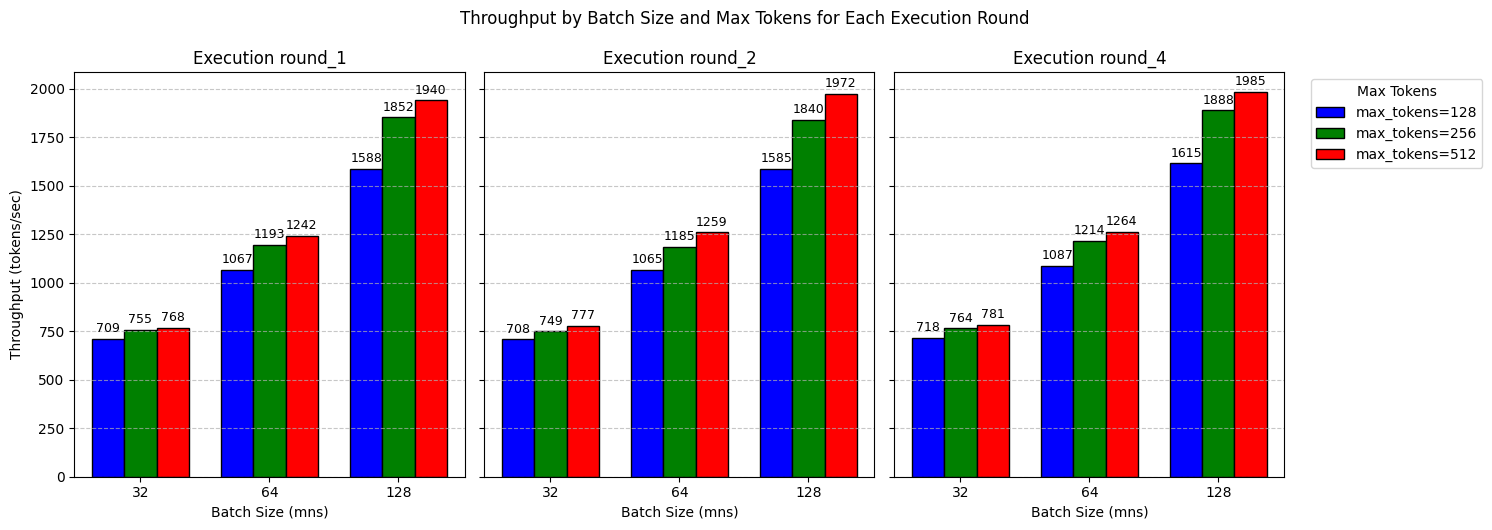

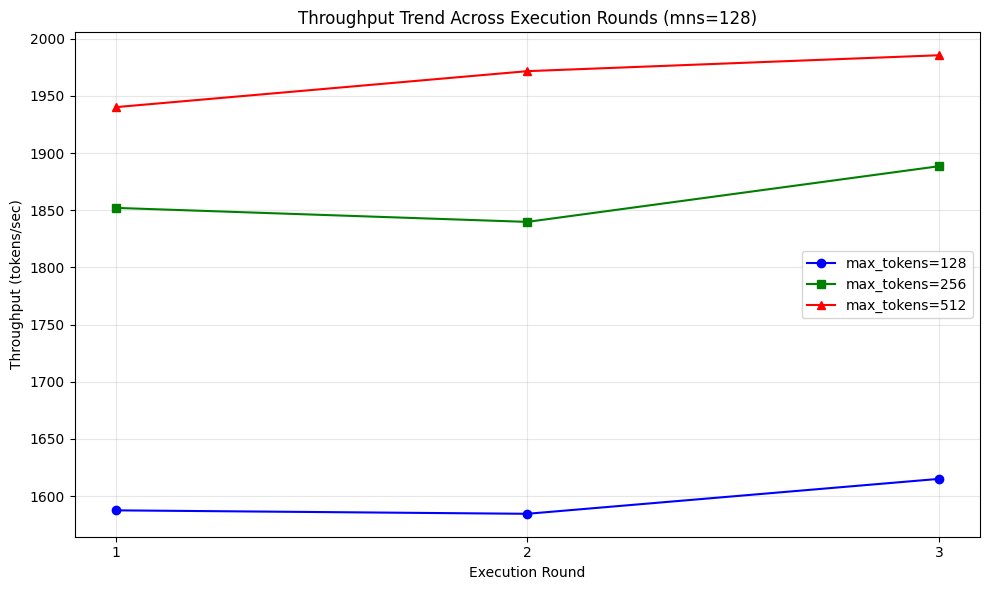

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with subplots for each execution round
num_rounds = len(structured_rounds)
fig, axes = plt.subplots(1, num_rounds, figsize=(5*num_rounds, 5), sharey=True)

# If there's only one round, make sure axes is a list
if num_rounds == 1:
    axes = [axes]

# Colors for different max_tokens values
colors = {'128': 'blue', '256': 'green', '512': 'red'}
markers = {'128': 'o', '256': 's', '512': '^'}

# Define batch sizes (mns) and max tokens values
batch_sizes = [32, 64, 128]  # In ascending order for better visualization
max_tokens_values = [128, 256, 512]

# For each round, create a plot
for i, (round_name, round_data) in enumerate(structured_rounds.items()):
    ax = axes[i]
    
    # Create data structure for plotting
    x_positions = np.arange(len(batch_sizes))
    width = 0.25
    
    # Plot bars for each max_tokens value
    for j, max_tokens in enumerate(max_tokens_values):
        throughputs = []
        
        # Collect throughput for each batch size with this max_tokens value
        for mns in batch_sizes:
            throughput = round_data[mns][max_tokens]['token_per_second']
            throughputs.append(throughput)
        
        # Plot as grouped bars
        offset = (j - 1) * width
        bars = ax.bar(x_positions + offset, throughputs, width, 
                      label=f'max_tokens={max_tokens}',
                      color=colors[str(max_tokens)],
                      edgecolor='black')
        
        # Add value labels on top of bars
        for k, bar in enumerate(bars):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                    f'{throughputs[k]:.0f}', 
                    ha='center', va='bottom', fontsize=9)
    
    # Set labels and title
    ax.set_xlabel('Batch Size (mns)')
    if i == 0:
        ax.set_ylabel('Throughput (tokens/sec)')
    ax.set_title(f'Execution {round_name}')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(batch_sizes)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    if i == num_rounds - 1:  # Only add legend to last subplot
        ax.legend(title='Max Tokens', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle('Throughput by Batch Size and Max Tokens for Each Execution Round', y=1.05)
plt.savefig('throughput_by_round.png', bbox_inches='tight', dpi=300)
plt.show()

# Alternative visualization: line plot with markers
plt.figure(figsize=(10, 6))

for max_tokens in max_tokens_values:
    # Collect throughput across all rounds for this max_tokens value and mns=128
    throughputs = []
    for round_name, round_data in structured_rounds.items():
        throughput = round_data[128][max_tokens]['token_per_second']
        throughputs.append(throughput)
    
    plt.plot(range(1, len(structured_rounds) + 1), throughputs, 
             marker=markers[str(max_tokens)], linestyle='-', 
             label=f'max_tokens={max_tokens}', color=colors[str(max_tokens)])

plt.xlabel('Execution Round')
plt.ylabel('Throughput (tokens/sec)')
plt.title('Throughput Trend Across Execution Rounds (mns=128)')
plt.xticks(range(1, len(structured_rounds) + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
#plt.savefig('throughput_trend_mns128.png', dpi=300)
plt.show()